## Predicting Macroeconomic Indices for 2023: A Deep Learning Approach with RNNs

**Explanation:**

below, the methods used to forecast some key macroeconomic indices, such as Inflation and GDP, for the year 2023 will be explained. The source data come from Eurostat, an authoritative source that provides up-to-date data on multiple areas.

For forecasting, we adopted the approach of Recurrent Neural Networks (RNN), a specialization in the field of deep learning suitable for temporal data sequences. In our case, data from 2017 to 2022 were used as a reference to make forecasts for the year 2023.

The size of the dataset is a key element in the choice of model architecture. While RNN was adequate for the dataset that was used, which wasn't extensive, variants such as LSTM or GRU (Gated Recurrent Units) could be considered for larger datasets or more detailed time intervals.

In the hyperparameter optimization phase of the model, I chose to use the Optuna framework, designed specifically to explore and identify the best combinations of parameters. Finally, for those working with more detailed datasets, such as quarterly or semiannual data, an advanced option might be to group countries with similar economic profiles using clustering techniques, such as KNN or Hierarchical clustering.

**Steps made:**
1. Standardization process
2. Optuna search best params
3. Use best params to create model (also adjusting for some params tested)
4. Predictions for 2023

**Some consideration:**

given the nature of the small dataset, I chose to take a multivariate approach by integrating the time series, even though this presents specific challenges. Complex deep learning models, in the presence of limited datasets, run the risk of overfitting, compromising generalization. However, by taking appropriate measures such as regularization, cross-validation and careful optimization of hyperparameters, such challenges can be overcome while achieving satisfactory results. Therefore, depending on the objectives, it is up to the user to experiment with Machine Learning or Deep Learning models and select the one deemed most suitable.

**Note**
* This notebook is designed to showcase my personal approach and is not intended as formal guidance or advice.
* For clarity, certain sections of the code (like data extraction, analysis, and preparation) have been omitted to emphasize the core aspects of this notebook. If you're interested on see all parts, visit my GitHub repository --> https://github.com/filcode/corporate_prediction_deep_learning. (if're not already there :) )

### <u>About Data</u>

**Time Span:**

2017 to 2022
   
**Geographical Coverage:**

- European Union (EU)
- Eastern European Union (EEU)

**Variables Included (name assigned, Eurostat code and description):**

***1. Demographic***

- **'PopDens'** (TPS00003): Population Density (Persons per square kilometre)

***2. Macroeconomic***

- **'RealGDPGRChg(%)'** (TEC00115): Yearly Change in Real GDP Growth Rate
- **'GrDebtToGDP(%)'** (SDG_17_40): Gross Debt as Percentage of GDP
- **'GovExpToGDP(%)'** (TEC00023): Government Expenditure as Percentage of GDP
- **'IntTdGoods'** (TET00002): Net Trade of Goods (excluding EFTA countries)

***3. Population & Labor***

- **'EmpDomCon'** (TEC00112): Number of People Employed in the Country
- **'DepOnWorkP(%)'** (DEMO_PJANIND__custom_6776614): Dependency on Working Population
- **'EduLev3(5-8)(%)'** (EDAT_LFSE_03__custom_6767752): Percentage of Population with Tertiary Education (levels 5-8)
- **'InduCostChg(%)'** (LC_LCI_R2_A__custom_6999771): Yearly Change in Labor Industry Cost
- **'HICPChg(%)'** (PRC_HICP_AIND__custom_7000055): Harmonized Index of Consumer Prices (Please verify the selected basket of goods)

### <u>Set Up environment</u>

In [1]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error


from tensorflow.keras import datasets, layers, models
from tensorflow import keras

from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
# VISUALIZE TABLE: ',None'
# VISUALIZE JUST SUBSET: remove ',None'
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data

***Running code below you can connect to dataset and print (also save***

In [3]:
def read_gdrive_to_df(file_id):
    """
    Read an Excel file from Google Drive using its file ID and return a DataFrame.
    """
    base_url = f'https://drive.google.com/file/d/{file_id}/view?usp=sharing'
    download_url = 'https://drive.google.com/uc?id=' + base_url.split('/')[-2]
    return pd.read_excel(download_url, index_col=0)

# Dataset
df_all_replaced_link = '104-UdrHarSqFCWlDxpewvWT0XmiaBMPu'
# df_normalize_link = '1hFZkvm_r3arVSv-VyUzCOStub9KLupHk'
# df_mean_distance_link = '10iqaD8LEWDXpb1qKfHNNvNdVvODkW1Ap'

# Countries group custom
group1_link = '1SeBohyPghZlnyAA4m0i-jNUpsVF1IH8V'
group2_link = '1CjfgPobiWVD4I8oA8dTVLFjOpDsNbJ2J'
group3_link = '1et8qCxbgSucKb7zYkb698izsPpM2Reoa'

# Read files using the function
df_all_replaced = read_gdrive_to_df(df_all_replaced_link) # original data with no nan
# df_normalize = read_gdrive_to_df(df_normalize_link) # normalized data (all changed by previous year difference)
# df_mean_distance = read_gdrive_to_df(df_mean_distance_link) # mean distance from year for each country
   
# # Read files using the function
group1 = read_gdrive_to_df(group1_link) 
group2 = read_gdrive_to_df(group2_link) 
group3 = read_gdrive_to_df(group3_link) 

In [4]:
len(df_all_replaced)

300

### Converting specific columns to categorical

In [5]:
columns_to_convert = ['geo', 'country', 'year']

for col in columns_to_convert:
    if col in df_all_replaced.columns:
        df_all_replaced[col] = df_all_replaced[col].astype('category')
        
data = df_all_replaced.copy()

**Mapping**

In [6]:
df_knn = df_all_replaced

# LSTM Model

predictions made by:
- by europe as a whole
- by clusters (group of countries with similarities)

**ATTENTION** following will be **two options** *<u>LSTM + Optuna (to get best params)</u>* and *<u>Manual LSTM settings</u>*. If you run Optuna it will take some times to get best params, so with the following I already run it and got best params that has been used.

## <u> UDF (User-Defined Function) will be used to plot Loss and print Error

**Train and validation history**

In [19]:
def plot_training_history(history):
    """
    Funzione per tracciare la storia del training del modello Keras.

    Parametri:
        history: Oggetto History ritornato dalla funzione model.fit() di Keras.

    Output:
        Mostra un grafico con la training loss e la validation loss.
    """
    
    # Estrai i dati della storia del training
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)  # Potrebbe non esserci una validation loss
    epochs_range = range(1, len(train_loss) + 1)  # Le epoche partono da 1
    
    plt.figure(figsize=(12, 6))
    
    # --- Grafico della Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')
    
    # --- Grafico della Training e Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.tight_layout()
    plt.show()

**Error**

In [20]:
def evaluate_model(model, history, X_valid, y_valid, scaler):
    # Valutation loss
    print('Valutation loss')
    test_loss = model.evaluate(X_valid, y_valid)
    print(f'Test Loss: {test_loss}')

    # Use history to get the final training and validation loss
    print(f"Final training loss: {history.history['loss'][-1]}")
    print(f"Final validation loss: {history.history['val_loss'][-1]}")

    print('\nError')
    # Predictions on the validation set
    predictions = model.predict(X_valid)

    # Invert the scaling for predictions
    inv_predictions = scaler.inverse_transform(predictions)

    # Invert the scaling for actual values
    inv_y_valid = scaler.inverse_transform(y_valid)

    # Calculate metrics
    mse = mean_squared_error(inv_y_valid, inv_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(inv_y_valid, inv_predictions)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')

    return mse, rmse, mae, inv_predictions, inv_y_valid

<!--  -->

<!--  -->

## Predicting EU and EEU countries 

### <u>1. Preprocessing</u>

In [7]:
from sklearn.preprocessing import StandardScaler

# ---- Make standardization all col
df_sorted = df_knn.sort_values(by=['year', 'country'])
df_values = df_sorted.drop(columns=['geo', 'country', 'year', 'ToTPop.'])

data_matrix = df_values.values.reshape(len(df_all_replaced['year'].unique()), -1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_matrix)

### Train-Validation Split

In [12]:
train = scaled_data[:]
valid = scaled_data[4:]
X_train, y_train = prepare_data(train, 5)
X_valid, y_valid = prepare_data(valid, 5)

In [13]:
X_train.shape

(5, 5, 300)

In [14]:
y_train.shape

(5, 300)

### <u>2. LSTM Model + Optuna

In [15]:
import optuna
import random
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, GRU, LSTM, SimpleRNN
from tensorflow.keras.initializers import GlorotNormal, HeNormal, GlorotUniform

In [1187]:
tf.keras.backend.clear_session()

def objective(trial, X_train, y_train, X_valid, y_valid, n_steps=None, 
                                  n_input_units=None, epochs=None, weight_initializer=None): # seed=None
    
    #     # Hyp opt
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_units = trial.suggest_int('n_units', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    activation_function = trial.suggest_categorical('activation_function', ['tanh', 'LeakyReLU', 'PReLU', 'softplus', 'elu']) # mish
#   batch_size = trial.suggest_int('batch_size', 16, 128, log=True) # log scale to explore bigger range values, give enph to smaller val
    
    if weight_initializer == 'GlorotNormal':
        initializer = GlorotNormal(seed=trial.number)
    elif weight_initializer == 'HeNormal':
        initializer = HeNormal(seed=trial.number)
    else:
        initializer = GlorotUniform(seed=trial.number) # Default

    model = Sequential()

    # Input Layer
    model.add(LSTM(n_units, activation=activation_function, return_sequences=True, input_shape=(n_steps, n_input_units), kernel_initializer=initializer))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Hidden Layers
    for _ in range(n_layers - 1):  # Added n_layers - 1 additional LSTM layers
        model.add(LSTM(n_units, activation=activation_function, return_sequences=True, kernel_initializer=initializer))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())

    # Ultimo Layer LSTM (prima del layer Dense) con return_sequences impostato su False
    model.add(LSTM(n_units, activation=activation_function, kernel_initializer=initializer))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(n_input_units))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    # Fit the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_valid, y_valid), callbacks=[early_stop, reduce_lr])

    # Get the minimum validation loss
    val_loss = min(history.history['val_loss'])

    return val_loss

In [16]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid, 5,
                                       X_train.shape[2], 150, weight_initializer=None), n_trials=150) # seed=trial.number

In [512]:
def print_study_results(studies):
    """
    This feature accepts a list of Optuna studies and prints the results of the best trial for each of them.
    """
    for idx, study in enumerate(studies, 1):
        print(f"--- Study {idx} ---")
        print('Number of finished trials: ', len(study.trials), '(it is also seed number)')
        print('Best trial:')
        trial = study.best_trial
        print('Value: ', trial.value)
        print('Params: ', trial.params)
        print('Seed: ', trial.number)
        print('---' * 10)  # to separate studies with lines

In [513]:
# Utilizzo della funzione:
studies = [study]
print_study_results(studies)

--- Study 1 ---
Number of finished trials:  150 (it is also seed number)
Best trial:
Value:  0.03339410945773125
Params:  {'n_layers': 1, 'n_units': 62, 'dropout_rate': 0.27767537586361435, 'learning_rate': 0.0022584377651873972, 'batch_size': 32, 'activation_function': 'elu'}
Seed:  21
------------------------------


In [380]:
# Best params found by Optuna
best_params_whole = study.best_params

### <U>LSTM manual passing best params found by Optuna</u>
You can directly pass the best parameters found by Optuna, but this approach allows for manual adjustments if needed.

In [17]:
def create_and_train_model_manual(algo=None, X_train=None, y_train=None, X_valid=None, y_valid=None, 
                                  n_steps=None, n_layers=None, n_units_2=None,
                                  n_units=None, dropout_rate=None, 
                                  learning_rate=None, batch_size=None, n_input_units=None, 
                                  epochs=None, activation_function=None,
                                  weight_initializer='GlorotUniform', seed=None):
    
    print('Model used', algo)
    
    if weight_initializer == 'GlorotNormal':
        initializer = GlorotNormal()
    elif weight_initializer == 'HeNormal':
        initializer = HeNormal()
    else:
        initializer = GlorotUniform()  # Default initializer

    model = Sequential()

    # Input Layer
    model.add(algo(n_units_2, return_sequences=True, activation=activation_function, input_shape=(n_steps, n_input_units), kernel_initializer=initializer))
    model.add(Dropout(dropout_rate))
#     model.add(BatchNormalization())

    # Hidden Layers
#     for _ in range(n_layers - 1):  # Aggiungiamo n_layers - 1 layer LSTM aggiuntivi
#         model.add(algo(n_units, activation=activation_function, return_sequences=True, kernel_initializer=initializer))
#         model.add(Dropout(dropout_rate))
#         model.add(BatchNormalization())

    # Second layer
    model.add(algo(n_units, activation=activation_function, kernel_initializer=initializer))
    model.add(Dropout(dropout_rate))
#     model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(n_input_units))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_valid, y_valid), callbacks=[early_stop, reduce_lr], verbose=1)
    
    plot_training_history(history)
    
    return model, history

Model used <class 'keras.src.layers.rnn.simple_rnn.SimpleRNN'>
Epoch 1/200


C:\Users\utente\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 3s 3s/step - loss: 1.6779 - val_loss: 2.1425 - lr: 0.0023
Epoch 2/200
1/1 [==============================] - 0s 77ms/step - loss: 1.4414 - val_loss: 1.8372 - lr: 0.0023
Epoch 3/200
1/1 [==============================] - 0s 79ms/step - loss: 1.2084 - val_loss: 1.5252 - lr: 0.0023
Epoch 4/200
1/1 [==============================] - 0s 78ms/step - loss: 1.0630 - val_loss: 1.1988 - lr: 0.0023
Epoch 5/200
1/1 [==============================] - 0s 77ms/step - loss: 1.0449 - val_loss: 0.9283 - lr: 0.0023
Epoch 6/200
1/1 [==============================] - 0s 73ms/step - loss: 0.8638 - val_loss: 0.6931 - lr: 0.0023
Epoch 7/200
1/1 [==============================] - 0s 76ms/step - loss: 0.7482 - val_loss: 0.5069 - lr: 0.0023
Epoch 8/200
1/1 [==============================] - 0s 70ms/step - loss: 0.6115 - val_loss: 0.3664 - lr: 0.0023
Epoch 9/200
1/1 [==============================] - 0s 66ms/step - loss: 0.6136 - val_loss: 0.2689 - lr: 0.0023
Epoch 10/200
1/

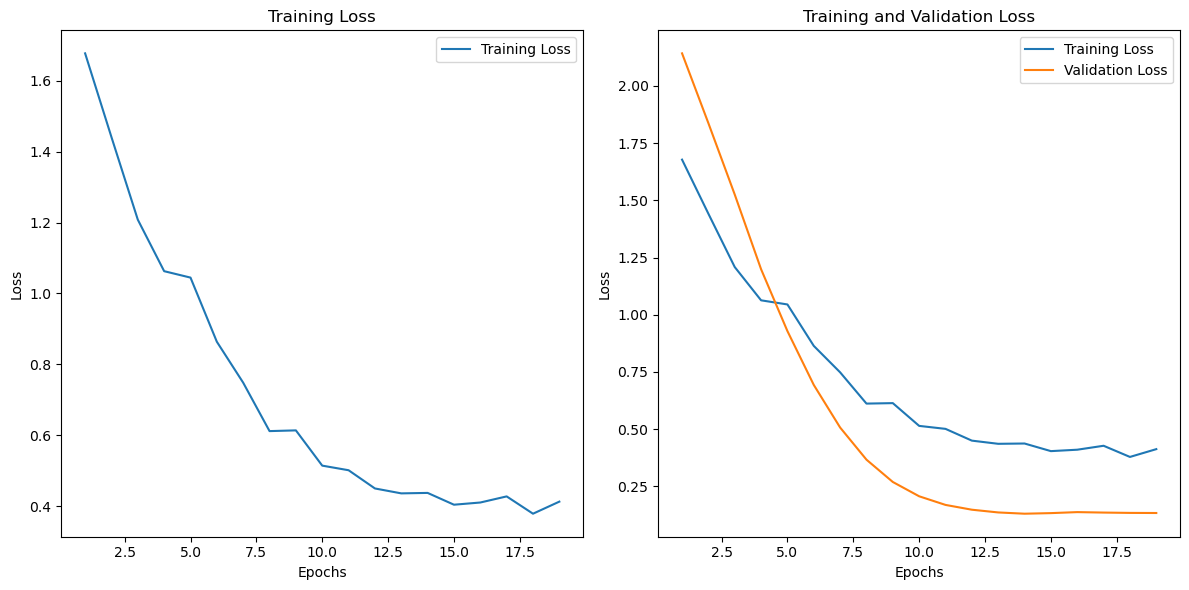

In [111]:
# resets the internal state of backend, freeing memory and preventing interference between consecutive models.
tf.keras.backend.clear_session() 

# best params found by Optuna
best_params = {'n_layers': 1, 'n_units': 62, 'dropout_rate': 0.27767537586361435, 'learning_rate': 0.0022584377651873972, 'batch_size': 32, 'activation_function': 'elu'}

# setting params using previous udf
model, history = create_and_train_model_manual(algo=SimpleRNN,
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                X_valid=X_valid, 
                                                y_valid=y_valid,
                                                n_steps=5,
                                                n_layers=best_params['n_layers'],
                                                n_units_2= 300, # None,
                                                n_units=240, # best_params['n_units'],
                                                dropout_rate=best_params['dropout_rate'], 
                                                learning_rate=best_params['learning_rate'],
                                                batch_size=32, # best_params['batch_size'],
                                                n_input_units=X_train.shape[2],
                                                epochs=200,
                                                activation_function= 'tanh', #'LeakyReLU'
                                                weight_initializer='GlorotUniform', # 'HeNormal', 'GlorotNormal'
                                                seed=np.random
                                            )

In [99]:
model

### Validation
Please focus on the loss rather than the error. Although the values have been standardized, they still have inherently different magnitudes because of their original natures (percent vs. whole number), making error a potentially anomalous indicator.

In [112]:
# Valutation loss
print('Valutation loss')
test_loss = model.evaluate(X_valid, y_valid)
print(f'Test Loss: {test_loss}')

# Use history to get the final training and validation loss
print(f"Final training loss: {history.history['loss'][-1]}")
print(f"Final validation loss: {history.history['val_loss'][-1]}")

print('\nError')
# Invert the scaling for predictions
predictions = model.predict(X_valid)
inv_predictions = scaler.inverse_transform(predictions)

# Invert the scaling for actual values
inv_y_valid = scaler.inverse_transform(y_valid)

# Calculate metrics
mse = mean_squared_error(inv_y_valid, inv_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_y_valid, inv_predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Valutation loss
1/1 [==============================] - 0s 29ms/step - loss: 0.1302
Test Loss: 0.13021479547023773
Final training loss: 0.4124375283718109
Final validation loss: 0.13326722383499146

Error
1/1 [==============================] - 0s 332ms/step
Mean Squared Error (MSE): 3165099.368082107
Root Mean Squared Error (RMSE): 1779.0726146175448
Mean Absolute Error (MAE): 272.38355183951063


### Columns considered to predictions

In [113]:
cols = ['PopDens', 'RealGDPGRChg(%)', 'GrDebtToGDP(%)',
       'GovExpToGDP(%)', 'IntTdGoods', 'EmpDomCon', 'DepOnWorkP(%)',
       'EduLev3(5-8)(%)', 'InduCostChg(%)', 'HICPChg(%)']

### Modelling

In [114]:
countries = sorted(df_all_replaced['country'].unique())
variables = cols  # These are your economic variables

# Reshaping the data
reshaped_actual = inv_y_valid.reshape(len(countries), len(variables))
reshaped_predictions = inv_predictions.reshape(len(countries), len(variables))

# Convert to DataFrame
actual_df = pd.DataFrame(reshaped_actual, columns=variables, index=countries)
predicted_df = pd.DataFrame(reshaped_predictions, columns=variables, index=countries)

comparison_df = pd.concat([actual_df, predicted_df], axis=1, keys=['Actual', 'Predicted'])

In [115]:
# If're interested in seeing difference between actual and predicted values
# difference_df = actual_df - predicted_df
# difference_df

### <u>4. Predictions for 2023</u>

In [116]:
def predict_future(model, last_data, n_steps, n_future, n_output_units=None):
    future_preds = []
    input_data = last_data[-n_steps:].tolist()
    for _ in range(n_future):
        # Reshape and predict
        input_array = np.array(input_data[-n_steps:])
        pred = model.predict(input_array.reshape(1, n_steps, n_output_units))
        
        # Append the prediction to future_preds and input_data
        future_preds.append(pred)
        input_data.append(pred[0])
        
    return np.array(future_preds)

In [117]:
# Predict for 2023, 2024 and 2025
n_steps = 5 # past periods considered
n_future = 3 # number years predicted
future_predictions = predict_future(model, scaled_data, n_steps, n_future, n_output_units=X_train.shape[2])

1/1 [==============================] - 0s 29ms/step


In [118]:
len(future_predictions)

3

In [119]:
reshaped_predictions = future_predictions.reshape(future_predictions.shape[0], -1)
# Invert scaling
unscaled_predictions = scaler.inverse_transform(reshaped_predictions)

In [120]:
unscaled_predictions.shape

(3, 300)

In [121]:
def create_prediction_dataframe(future_predictions, countries, predictors):
    """
    Args:
    - future_predictions: Array of shape (3, 240) with predictions for 2023, 2024, 2025.
    - countries: List of countries in Europe.
    - predictors: List of economic predictors.

    Returns:
    - DataFrame with future predictions for each country in Europe.
    """
    
    data_list = []
      
    # Create an empty dataframe with the specified columns
    columns = ['country', 'year'] + predictors
    df = pd.DataFrame(columns=columns)
    
    # Years for which predictions are available
    years = [2023, 2024, 2025]

    # Populate the dataframe
    for country_index, country in enumerate(countries):
        for year_index, year in enumerate(years):
            # Extract the prediction for that year for the specific country
            start_idx = country_index * len(predictors)
            end_idx = start_idx + len(predictors)
            country_predictions = future_predictions[year_index, start_idx:end_idx]
            
            # Create a new row for the dataframe
            data = {'country': country,
                    'year': year}
            
            # Add economic predictor values
            for j, predictor in enumerate(predictors):
                data[predictor] = country_predictions[j]

            # Append the data to the dataframe
            data_list.append(data)

    
    df = pd.DataFrame(data_list)
    
    return df

In [122]:
countries = df_all_replaced['country'].unique()  # Add all countries
predictors= cols
pred_df = create_prediction_dataframe(unscaled_predictions, countries, predictors)

### Predictions

In [128]:
pred_df[['country', 'year', 'RealGDPGRChg(%)', 'GrDebtToGDP(%)', 'GovExpToGDP(%)', 'DepOnWorkP(%)',
         'EduLev3(5-8)(%)', 'InduCostChg(%)', 'HICPChg(%)']][::3]

,country,year,RealGDPGRChg(%),GrDebtToGDP(%),GovExpToGDP(%),DepOnWorkP(%),EduLev3(5-8)(%),InduCostChg(%),HICPChg(%)
0,Austria,2023,-0.764172,79.895218,52.829174,50.985382,19.274612,4.793575,7.585292
3,Belgium,2023,0.228506,108.660278,55.725830,56.456665,23.744654,1.876399,5.912247
6,Bulgaria,2023,3.090296,18.731880,41.637939,55.583626,20.640200,8.758749,13.137529
9,Croatia,2023,3.426502,77.666428,46.675835,53.851177,18.618786,6.784200,5.240807
12,Cyprus,2023,3.210842,92.728439,38.858131,45.867622,19.795208,4.381270,2.439365
15,Czechia,2023,1.869134,35.678391,45.210918,52.457497,12.329314,4.940374,11.455482
18,Denmark,2023,1.241852,32.787891,50.388672,57.046162,24.921438,1.978882,3.914456
21,Estonia,2023,2.546486,18.605547,38.582191,55.521267,16.647821,7.999469,9.401677
24,Finland,2023,-0.121912,69.895210,53.562504,61.461720,18.585989,1.538211,3.010310
27,France,2023,0.655108,103.532967,56.384991,61.338940,22.581020,1.310273,2.984105


<!--  -->

<u>Some Comparison with other sources:</u>

**HICP(%)**
- [Eurostat - Italy](https://economy-finance.ec.europa.eu/economic-surveillance-eu-economies/italy/economic-forecast-italy_en#:~:text=HICP%20inflation%20is%20projected%20to,2023%20and%202.9%25%20in%202024.)
- [Eurostat - France](https://economy-finance.ec.europa.eu/economic-surveillance-eu-economies/france/economic-forecast-france_en#:~:text=Thus%2C%20headline%20inflation%20is%20expected,and%202.5%25%20in%202024)
- [Eurostat - Czechia](https://economy-finance.ec.europa.eu/economic-surveillance-eu-economies/czechia/economic-forecast-czechia_en#:~:text=The%20annual%20average%20inflation%20rate,and%20related%20spill%2Dover%20effects.)
- [Portuguese Public Finance Council - Portugal](https://www.cfp.pt/en/publications/economic-and-fiscal-outlook/economic-and-fiscal-outlook-2023-2027)

**GrDebtToGDP(%)**
- [FitchRatings - Italy](https://www.fitchratings.com/research/sovereigns/italy-significantly-loosens-its-fiscal-plans-11-10-2023)
- [European Commision - Denmark](https://economy-finance.ec.europa.eu/system/files/2023-06/ip228_en.pdf)
- [FitchRatings - Spain](https://www.fitchratings.com/research/sovereigns/fitch-affirms-spain-at-a-outlook-stable-26-05-2023)

**GovExpToGDP(%)**
- [Statista - Germany](https://fr.statista.com/outlook/co/macroeconomic-indicators/public-finance/germany#:~:text=The%20general%20government%20expenditure%20in,%E2%82%AC2.05tn%20by%202023.)
- [Portuguese Public Finance Council - Portugal](https://www.cfp.pt/en/publications/economic-and-fiscal-outlook/economic-and-fiscal-outlook-2023-2027)
- [Caixa Bank Research - Spain](https://www.caixabankresearch.com/en/economics-markets/public-sector/2023-2026-stability-programme-reduction-spains-budget-deficit)

<!--  -->

<!--  -->

***Thank you***

***Filippo Maria Mariani***